<a href="https://colab.research.google.com/github/trtrgfh/7sGNwtDKjIZW3Zfi/blob/main/Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("/content/term-deposit-marketing-2020.csv")
df.head(), df.shape

(   age           job  marital  education default  balance housing loan  \
 0   58    management  married   tertiary      no     2143     yes   no   
 1   44    technician   single  secondary      no       29     yes   no   
 2   33  entrepreneur  married  secondary      no        2     yes  yes   
 3   47   blue-collar  married    unknown      no     1506     yes   no   
 4   33       unknown   single    unknown      no        1      no   no   
 
    contact  day month  duration  campaign   y  
 0  unknown    5   may       261         1  no  
 1  unknown    5   may       151         1  no  
 2  unknown    5   may        76         1  no  
 3  unknown    5   may        92         1  no  
 4  unknown    5   may       198         1  no  ,
 (40000, 14))

In [3]:
df = df.drop(["job", "contact", "day", "month"], axis=1)
df.head(), df.shape

(   age  marital  education default  balance housing loan  duration  campaign  \
 0   58  married   tertiary      no     2143     yes   no       261         1   
 1   44   single  secondary      no       29     yes   no       151         1   
 2   33  married  secondary      no        2     yes  yes        76         1   
 3   47  married    unknown      no     1506     yes   no        92         1   
 4   33   single    unknown      no        1      no   no       198         1   
 
     y  
 0  no  
 1  no  
 2  no  
 3  no  
 4  no  ,
 (40000, 10))

In [4]:
# Get the unique items used in one-hot encoding columns
marital = df["marital"].unique()
education = df["education"].unique()

In [5]:
encoder = OneHotEncoder()

# Perform one-hot encoding on "marital" and "education" columns
encoder_marital = pd.DataFrame(encoder.fit_transform(df[["marital"]]).toarray(), columns = marital)
encoder_edu = pd.DataFrame(encoder.fit_transform(df[["education"]]).toarray(), columns = education)

# Merge one-hot encoded columns back with original DataFrame
df = df.join(encoder_marital)
df = df.join(encoder_edu)
df.rename(columns={'unknown':'unknown_edu'}, inplace=True)
df = df.drop(["marital", "education"], axis=1)

In [6]:
df.head()

age default  balance housing loan  duration  campaign   y  married  single  \
0   58      no     2143     yes   no       261         1  no      0.0     1.0   
1   44      no       29     yes   no       151         1  no      0.0     0.0   
2   33      no        2     yes  yes        76         1  no      0.0     1.0   
3   47      no     1506     yes   no        92         1  no      0.0     1.0   
4   33      no        1      no   no       198         1  no      0.0     0.0   

   divorced  tertiary  secondary  unknown_edu  primary  
0       0.0       0.0        0.0          1.0      0.0  
1       1.0       0.0        1.0          0.0      0.0  
2       0.0       0.0        1.0          0.0      0.0  
3       0.0       0.0        0.0          0.0      1.0  
4       1.0       0.0        0.0          0.0      1.0

In [7]:
df = df.replace(to_replace=['no', 'yes'], value=[0, 1])
df.head()

age  default  balance  housing  loan  duration  campaign  y  married  \
0   58        0     2143        1     0       261         1  0      0.0   
1   44        0       29        1     0       151         1  0      0.0   
2   33        0        2        1     1        76         1  0      0.0   
3   47        0     1506        1     0        92         1  0      0.0   
4   33        0        1        0     0       198         1  0      0.0   

   single  divorced  tertiary  secondary  unknown_edu  primary  
0     1.0       0.0       0.0        0.0          1.0      0.0  
1     0.0       1.0       0.0        1.0          0.0      0.0  
2     1.0       0.0       0.0        1.0          0.0      0.0  
3     1.0       0.0       0.0        0.0          0.0      1.0  
4     0.0       1.0       0.0        0.0          0.0      1.0

In [11]:
# Get feature and target dataset 
y = df[["y"]]
X = df.drop(["y"], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

(40000, 14)
(40000, 1)


In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0
model = xgb.XGBClassifier(learning_rate=0.3, gamma=0, reg_lambda=2, random_state=42)
overall = []

for train_index, test_index in kfold.split(X):
  # Get data
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
  # Train
  model.fit(X_train, y_train)
  # Predict
  pred_y_test = model.predict(X_test)
  accuracy = accuracy_score(y_test, pred_y_test)
  overall.append(accuracy)
  # Find best model
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model

# Save trained best model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [39]:
print(f"Average accuracy with 5-fold cross validation: {sum(overall) / len(overall)}")

Average accuracy with 5-fold cross validation: 0.9305249999999999


In [40]:
# Load best model
load_model = pickle.load(open("xgboost_model.pkl", "rb"))
pred_y = load_model.predict(X_train)
pred_y_test = load_model.predict(X_test)

In [41]:
y.value_counts()

y
0    37104
1     2896
dtype: int64

In [42]:
# Calculate metrics for training set
print("Training")
print(f"Train_Precision: {precision_score(y_train, pred_y)}")
print(f"Train_Recall: {recall_score(y_train, pred_y)}")
print(f"Train_F1score: {f1_score(y_train, pred_y)}")
print(f"Train_Accuracy: {accuracy_score(y_train, pred_y)}")

# Calculate metrics for testing set
print("Testing")
print(f"Test_Precision: {precision_score(y_test, pred_y_test)}")
print(f"Test_Recall: {recall_score(y_test, pred_y_test)}")
print(f"Test_F1score: {f1_score(y_test, pred_y_test)}")
print(f"Test_Accuracy: {accuracy_score(y_test, pred_y_test)}")

Training
Train_Precision: 0.8649754500818331
Train_Recall: 0.46237970253718286
Train_F1score: 0.6026225769669328
Train_Accuracy: 0.9564375
Testing
Test_Precision: 0.5759717314487632
Test_Recall: 0.26721311475409837
Test_F1score: 0.3650615901455767
Test_Accuracy: 0.929125


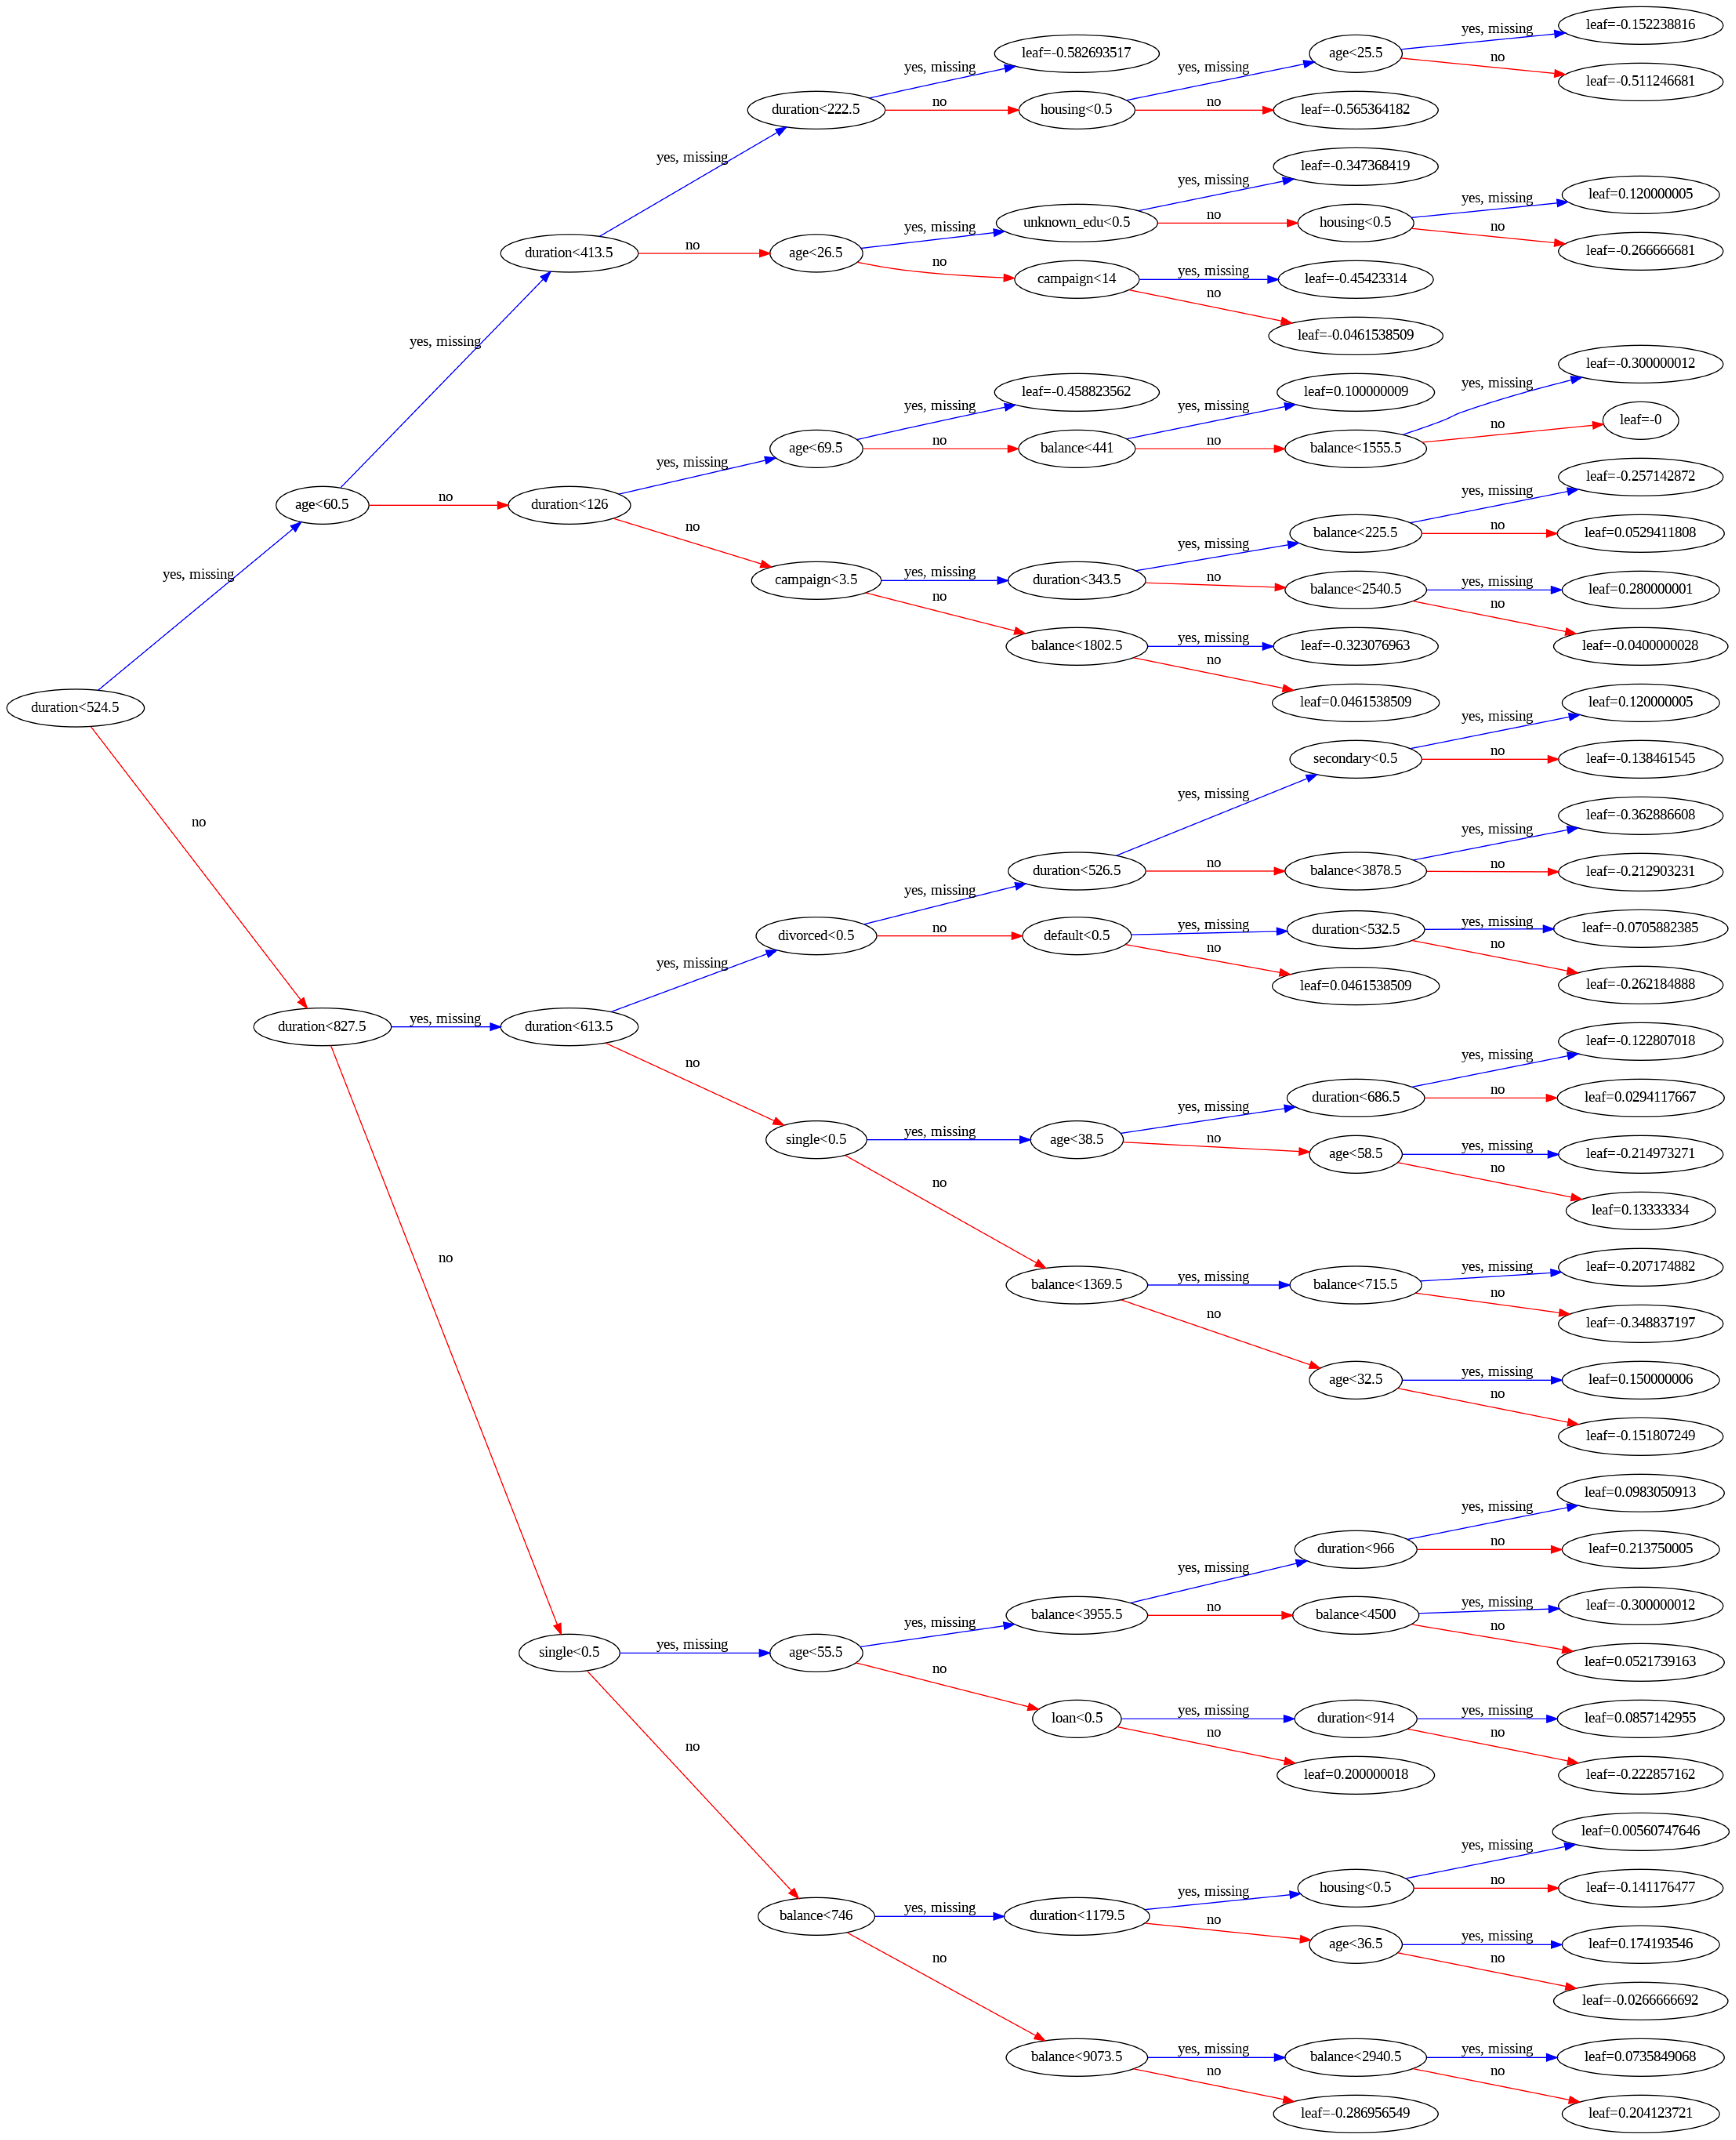

In [43]:
xgb.plot_tree(model, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig('figure1.png', bbox_inches='tight')
plt.show()